Motivation
=======

Plotting strength of optical transition matrix elements along high-symmetry k-points in band structure

Created with Python 2 and latest version of pymatgen in 2017 (several changes in pymatgen may necessitate some minor changes in plotting functions)

Alternative to heat maps of transition matrix elements

Requires:
Transmatrix,
POSCAR,
vasprun.xml,
KPOINTS file with high-symm points labelled

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colorbar
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import seaborn as sns
import pandas as pd
from IPython.display import Image
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf')
#set_matplotlib_formats('png','pdf')

import pymatgen as pmg
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.io.vasp.outputs import Vasprun, Procar
from pymatgen.electronic_structure.core import Spin, Orbital


from pymatgen.io.vasp.outputs import Vasprun, Procar
from pymatgen.symmetry.bandstructure import HighSymmKpath
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.plotter import BSPlotter
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
#%config InlineBackend.figure_format = 'pdf'

# enable TeX in plots
from matplotlib import rc
rc('text', usetex=False)
#rc('text', usetex=True)

## formatting the plot to be pretty
sns.set_style(style="ticks")
sns.set(font_scale=3,font='Calibri')

## COMMENT THIS TO SEE WARNINGS (particularly if running on a new version of Python or pymatgen)
import warnings
warnings.filterwarnings("ignore")


In [2]:
########################################################################################
# Read Transmatrix file, optical matrix elements
########################################################################################
def read_transmat(fold_name,transadd=False):
    """fold_name: folder name containing relevant files
       transadd : read from Transmatrix or Transmatrix_additional
    """
    # Transmatrix
    # what to call the columns, import data in to pandas dataframe
    if transadd:
        transmat = fold_name+"/Transmatrix_additional"
    else:
        transmat = fold_name+"/Transmatrix"
    transkey =['kwt','jbnd','ibnd','eig_j','eig_i','Re(px)','Im(px)','Re(py)','Im(py)','Re(pz)','Im(pz)']
    transdat = pd.read_csv(transmat,delim_whitespace=True,header=None,names=transkey,dtype=np.float32)
    
    # absolute modulus of optical matrix elements, by x,y,z components
    px2 = np.add(np.power(transdat['Re(px)'],2), np.power(transdat['Im(px)'],2))
    py2 = np.add(np.power(transdat['Re(py)'],2), np.power(transdat['Im(py)'],2))
    pz2 = np.add(np.power(transdat['Re(pz)'],2), np.power(transdat['Im(pz)'],2))
    
    # modulus of optical transition matrix elements
    #   ??? average over directions, not implemented ???
    pmn2 = np.add(np.add(px2,py2),pz2)
    pmn = np.power(pmn2,0.500)
    
    # return as new data frame containing containing
    #  jbnd, ibnd, eig_j, eig_i, |p_mn|
    d = {'jbnd': transdat['jbnd'],'ibnd': transdat['ibnd'],
            'eig_j': transdat['eig_j'],'eig_i': transdat['eig_i'],
            '|pmn|': pmn}
    pmndf = pd.DataFrame(data=d)

    return pmndf  # pandas DataFrame structure

########################################################################################
# Pick out transitions from Transmatrix file
########################################################################################
def sort_transmat(pmndf,ibnd,jbnds):
    """Pick out row of Transmatrix for transitions of interest
       Returns list of DataFrames 
       pmndf : DataFrame containing |pmn|, see read_transmat
       ibnd  : integer, intial band index
       jbnds : list, finals band indices"""

    pmnsub = pd.DataFrame()
    # pick out rows correponding to initial band ibnd
    tmp = pmndf.loc[pmndf['ibnd'] == ibnd]
    for j in range(len(jbnds)):
        jiter = jbnds[j]
        pmnsub = pmnsub.append(tmp.loc[tmp['jbnd'] == jiter])
    
    return pmnsub  # pandas DataFrame structure
    
########################################################################################
# Plot the projected band structure
########################################################################################
def plot_transmat(fold_name,sym_kpt,ax,ibnd,jbnds,transadd=False,xshift=0.0,enshift=0.0):
    """
    fold_name: string, folder name
    sym_kpt:   string, containing where KPOINTS file is
    ax:        axes handle, after initialize figure
    ibnd  : integer, intial band index
    jbnds : list, finals band indices
    transadd : read from Transmatrix or Transmatrix_additional
    xshift:      shift k-point path distance; default = 0.0
    enshift:     shift energy levels; default = 0.0
    """
    print (fold_name)
    
    # get bandstructure
    bands = Vasprun(fold_name+"/vasprun.xml").get_band_structure(sym_kpt, line_mode=True) 
    plotter=BSPlotter(bands)
    bs_data=plotter.bs_plot_data(zero_to_efermi=False)
    #bands.apply_scissor(6.18)
    kdist=np.empty(0)
    eng=np.empty(0)
    # bandstructure data
    bs_dist=bs_data['distances']
    bs_en=bs_data['energy']

    # Transmatrix optical matrix elements
    pmndf = read_transmat(fold_name,transadd=transadd)
    pmn = sort_transmat(pmndf,ibnd,jbnds)  
    # pmn = DataFrame w/ eig_j, eig_i, jbnd, ibnd, |pmn| w/ transitions of interest
    #print(pmn['|pmn|'])

    # figuring out distance along k-point path, e.g., for multiple branches or spins
    for ibranch in enumerate(bs_dist):
        branch_dist=np.array(ibranch[1])
        #eng=np.hstack([eng, bs_en_up]) if eng.size else bs_en_up ## 2017 pymatgen compatible
        eng=bs_en['1'][0]
        
        ## TODO compatibility with spin
        #bs_en_up=np.array(bs_en[ibranch[0]]['1'])
        #print ' dist', dist.shape
        #print 'kdist', kdist.shape
        kdist=np.hstack([kdist, branch_dist]) if kdist.size else branch_dist
        kdist=kdist+xshift

    # spline interpolating the each band
    from scipy.interpolate import interp1d,pchip
    xx=np.linspace(min(kdist),max(kdist),800)

    mask=(kdist[:-1]-kdist[1:]!=0)
    mask=np.hstack([mask,True])

    # boundaries of colorbar set here
    cmap = plt.get_cmap('viridis')
    ## linear bounds
    #bounds = np.linspace(np.min(pmn['|pmn|']),np.max(pmn['|pmn|']),50)
    #norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    #print("min val, max val:")
    #print(np.min(pmn['|pmn|']),np.min(pmn['|pmn|']))
    
    # Log bounds
    norm = mpl.colors.LogNorm(vmin=np.min(pmn['|pmn|']),vmax=np.min(pmn['|pmn|']))
    
    # split bands into small segments and plot at different thicknesses
    # superimpose color map for strength of optical transition matrix element
    mincolor=1e-21   # color scale min for log scaling
    maxcolor= np.max(pmn['|pmn|'])
    
    for iband in enumerate(eng):    
        itr=iband[0]
        # interpolate bands
        band_func = interp1d(kdist[mask], iband[1][mask], kind='cubic')
        
        # highlight initial band of interest, skip transmat bands
        if (itr+1) == ibnd:
            ax.plot(xx,band_func(xx)+enshift,'r-',linewidth=3)
        elif (itr+1) in jbnds:
            ax.plot(xx,band_func(xx)+enshift,'-', color="#787878",linewidth=0.3)
        else:
            ax.plot(xx,band_func(xx)+enshift,'k-', linewidth=1)
        
        # check if band included in transitions interest in, i.e., in jbnds
        if (itr+1) in jbnds:
            #print("interpolating transmatrix band")
            #print(itr+1)
            tmp = pmn.loc[pmn['jbnd'] == itr+1]
            # 'cubic' interpolation leads to negative values
            trans_funcs = interp1d(kdist[mask], np.array(tmp['|pmn|'])[mask], kind='slinear')
            #trans_funcs = pchip(kdist[mask], np.array(tmp['|pmn|'])[mask])
            
            # interpolation of optical matrix elements
            trans_val = trans_funcs(xx[:-1])
        
            # scheme for scaling line thickness and color according to transition strength
            ## logarithmic transformation
            #lwidths=10*np.nan_to_num(-1.0/np.log10(trans_val))
            #lcolors=np.nan_to_num(-1.0/np.log10(trans_val))
            
            # yet another linear scale
            #lwidths=10*(np.power(10,trans_val)-1.0)
            #lcolors=(np.power(10,trans_val)-1.0)
            
            #norm = mpl.colors.LogNorm(vmin=mincolor,vmax=maxcolor)#, cmap=cmap.N)
            norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1.0)
                
            # with linear normalization of colorbar
            lwidths=30*trans_val+2.
            lcolors=trans_val
                                
            #print(np.min(lcolors),np.max(lcolors))
            #print(mincolor,maxcolor)
            #print(norm)
            
            # make list of x,y pair coordinates
            points = np.array([xx, band_func(xx)+enshift]).T.reshape(-1, 1, 2)
            # make segments, pair points two away from each other
            segments = np.concatenate([points[:-2], points[2:]], axis=1)
            lc = LineCollection(segments, linewidths=lwidths,cmap=plt.get_cmap('viridis'),norm=norm)
            lc.set_array(lcolors)
            ax.add_collection(lc)
            
            #ax.plot(kdist[mask], iband[1][mask], 'ko', ms=2
            
        # plot only up to last band of interest
        if (itr+1) >= jbnds[-1]:
            break
    

    plt.xticks(color='w') ## hide xticks - comment to show
    ## create high-symmetry point ticks
    #tix_dict=bs_data['ticks']
    #print (tix_dict)
    #ax.set_xticks(np.array(tix_dict['distance'])+xshift)
    
    
    # x-axes with high-symmetry labels and line
    #ax.set_xlim(tix_dict['distance'][0]+xshift,tix_dict['distance'][-1]+xshift)
    #ax.set_xticklabels(tix_dict['label'])
    #for xtpt in tix_dict[u'distance']:
    #    ax.axvline(xtpt+xshift,-100,100,color="#505050",lw=1,zorder=1)
    #return tix_dict[u'distance'][-1]+xshift
########################################################################################

## Monoclinic HSE

Transmatrix-bs/mono-hse/


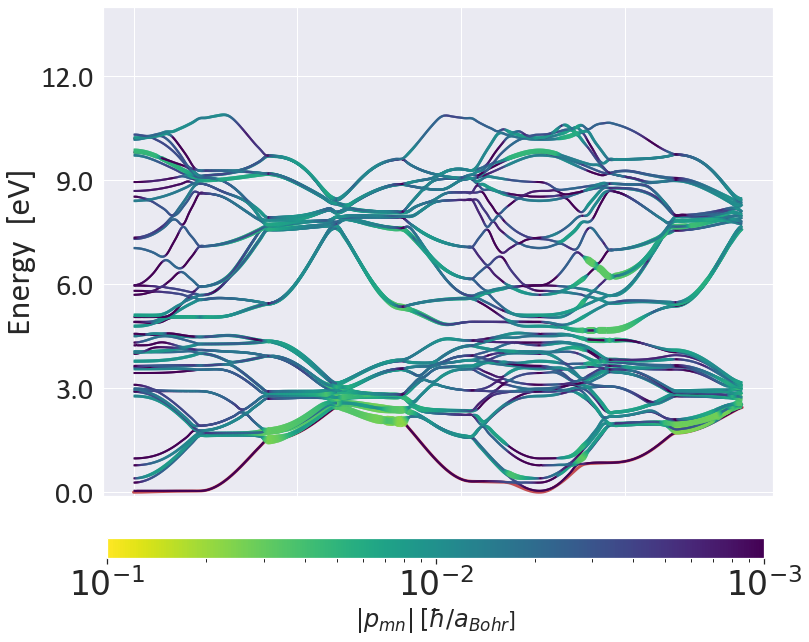

In [3]:
### CB -> CB 
## Note: tailored files- removed non-zero weighted kpoints in KPOINTS, Transmatrix*
fold_name = 'Transmatrix-bs/mono-hse/'
sym_kpt = fold_name+"/KPOINTS"
cbm = 1.9953
ibnd = 97   # CBM
jbnds = range(98,144) # need extend ADDBANDS to more

fig,ax1 = plt.subplots(1,1,figsize=[12,9],sharey=True)
plot_transmat(fold_name,sym_kpt,ax1,ibnd,jbnds,transadd=True,xshift=0.0,enshift=-cbm)

#ytix=[-3.0,0.0,3.0,6.0,9.0,12.0]#np.linspace(-3,15,7,endpoint=True)
ytix=[0.0,3.0,6.0,9.0,12.0]#np.linspace(-3,15,7,endpoint=True)
ax1.set_ylim(-0.1,14)
#ytix=np.linspace(-12,15,10,endpoint=True)
#ax1.set_ylim(-10,14)
ax1.set_yticks(ytix)
ax1.set_yticklabels(ytix,fontsize=30)
ax1.set_ylabel(r'Energy  [eV]',fontdict={'size':34})

# Draw the colorbar on the side of the figure
ax3 = fig.add_axes([0.13, 0.03, 0.76, 0.03])
#bounds = np.linspace(0,0.3,30)  # put min and max of |p_mn| here
cmap = plt.get_cmap('viridis_r')

norm = mpl.colors.LogNorm(vmin=1e-3,vmax=1e-1)
cb = mpl.colorbar.ColorbarBase(ax3, cmap=cmap, norm=norm,orientation='horizontal',spacing='proportional', 
                               ticks=[1.e-3,1.e-2,1.e-1], format='%1i')
#cb.ax.invert_xaxis() # increasing from left to right
cb.set_ticklabels([r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$']) # should match with above ticks options
cb.set_label(r"$|p_{mn}|$ $[\hbar/a_{Bohr}$]",fontdict={'size':24})


#fig.savefig("test.pdf", dpi=600,
#               bbox_inches='tight', 
#               transparent=True,
#               pad_inches=0)